In [1]:
!pip uninstall opencv-python -y

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30


In [2]:
!pip install opencv-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 1.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6 MB 1.6 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


Left image


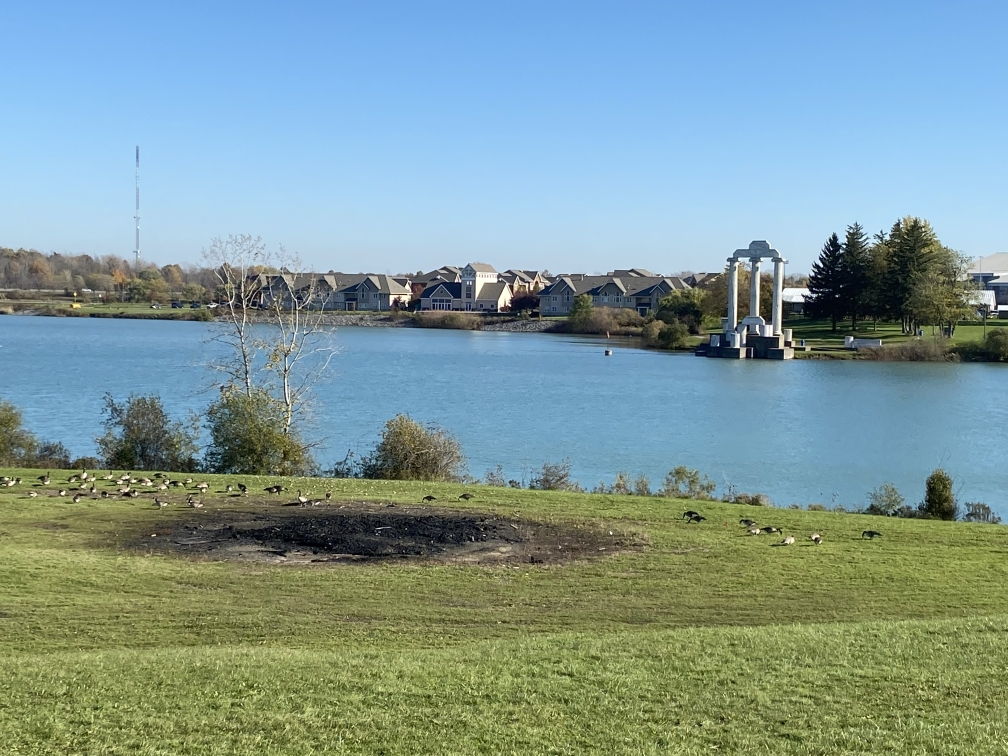

Right image


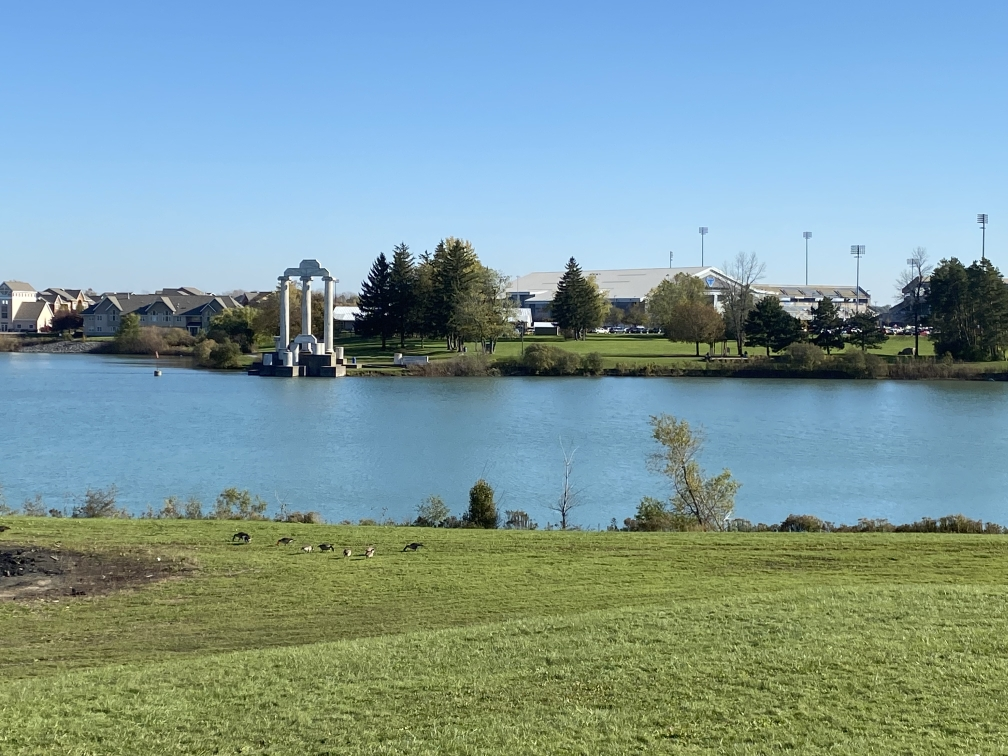

Keypoints on original Image


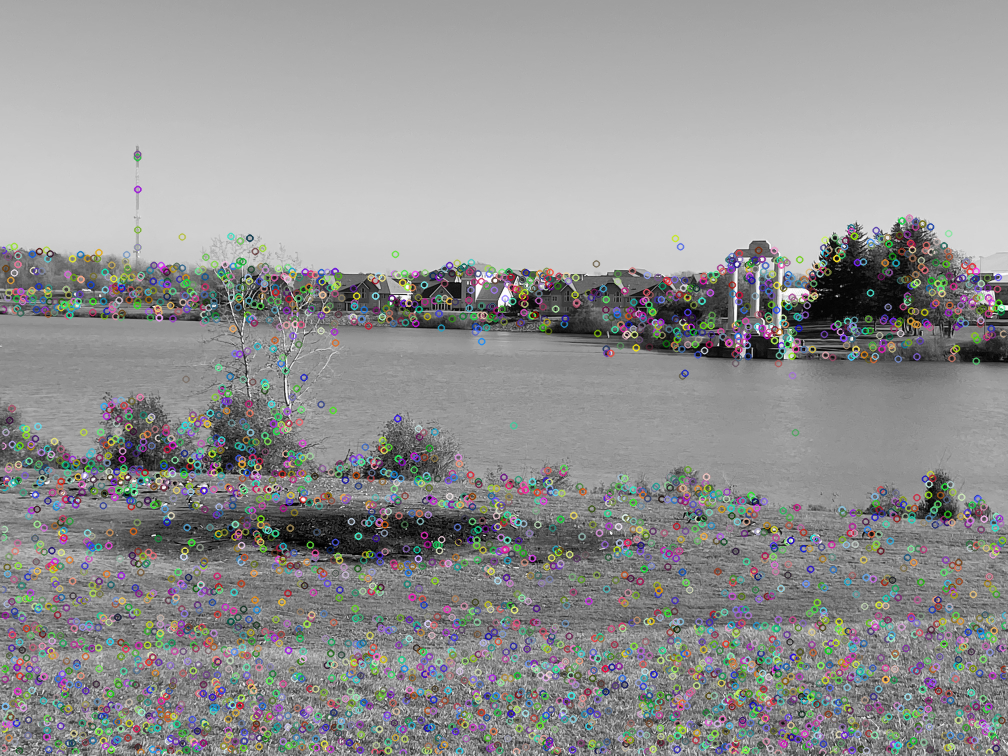

Keypoints on original Image


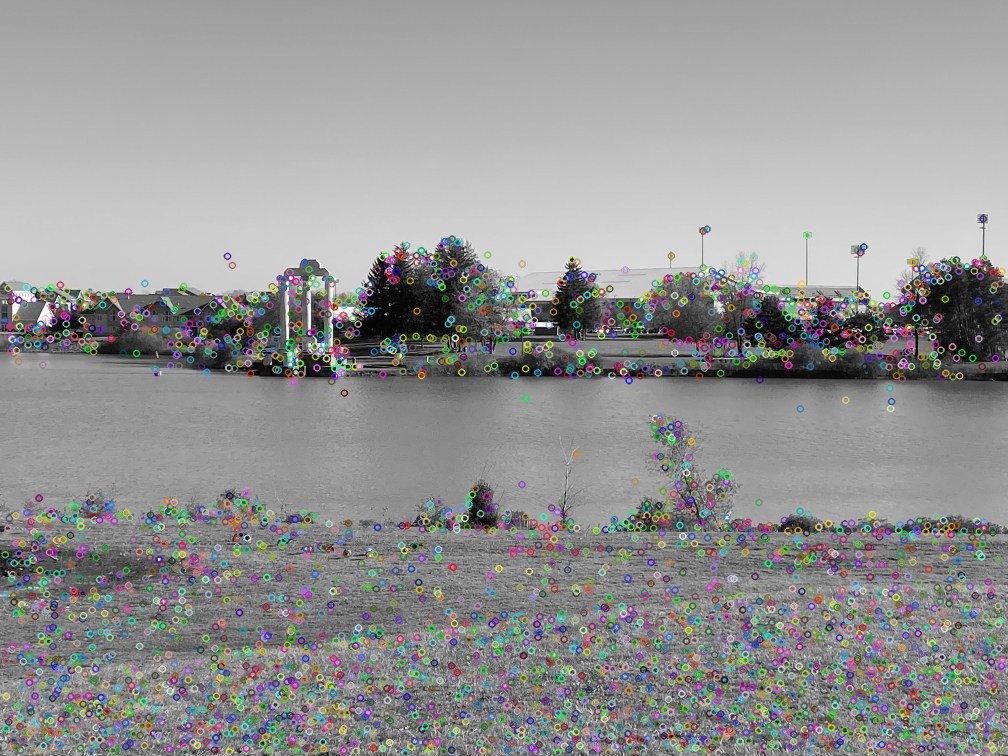

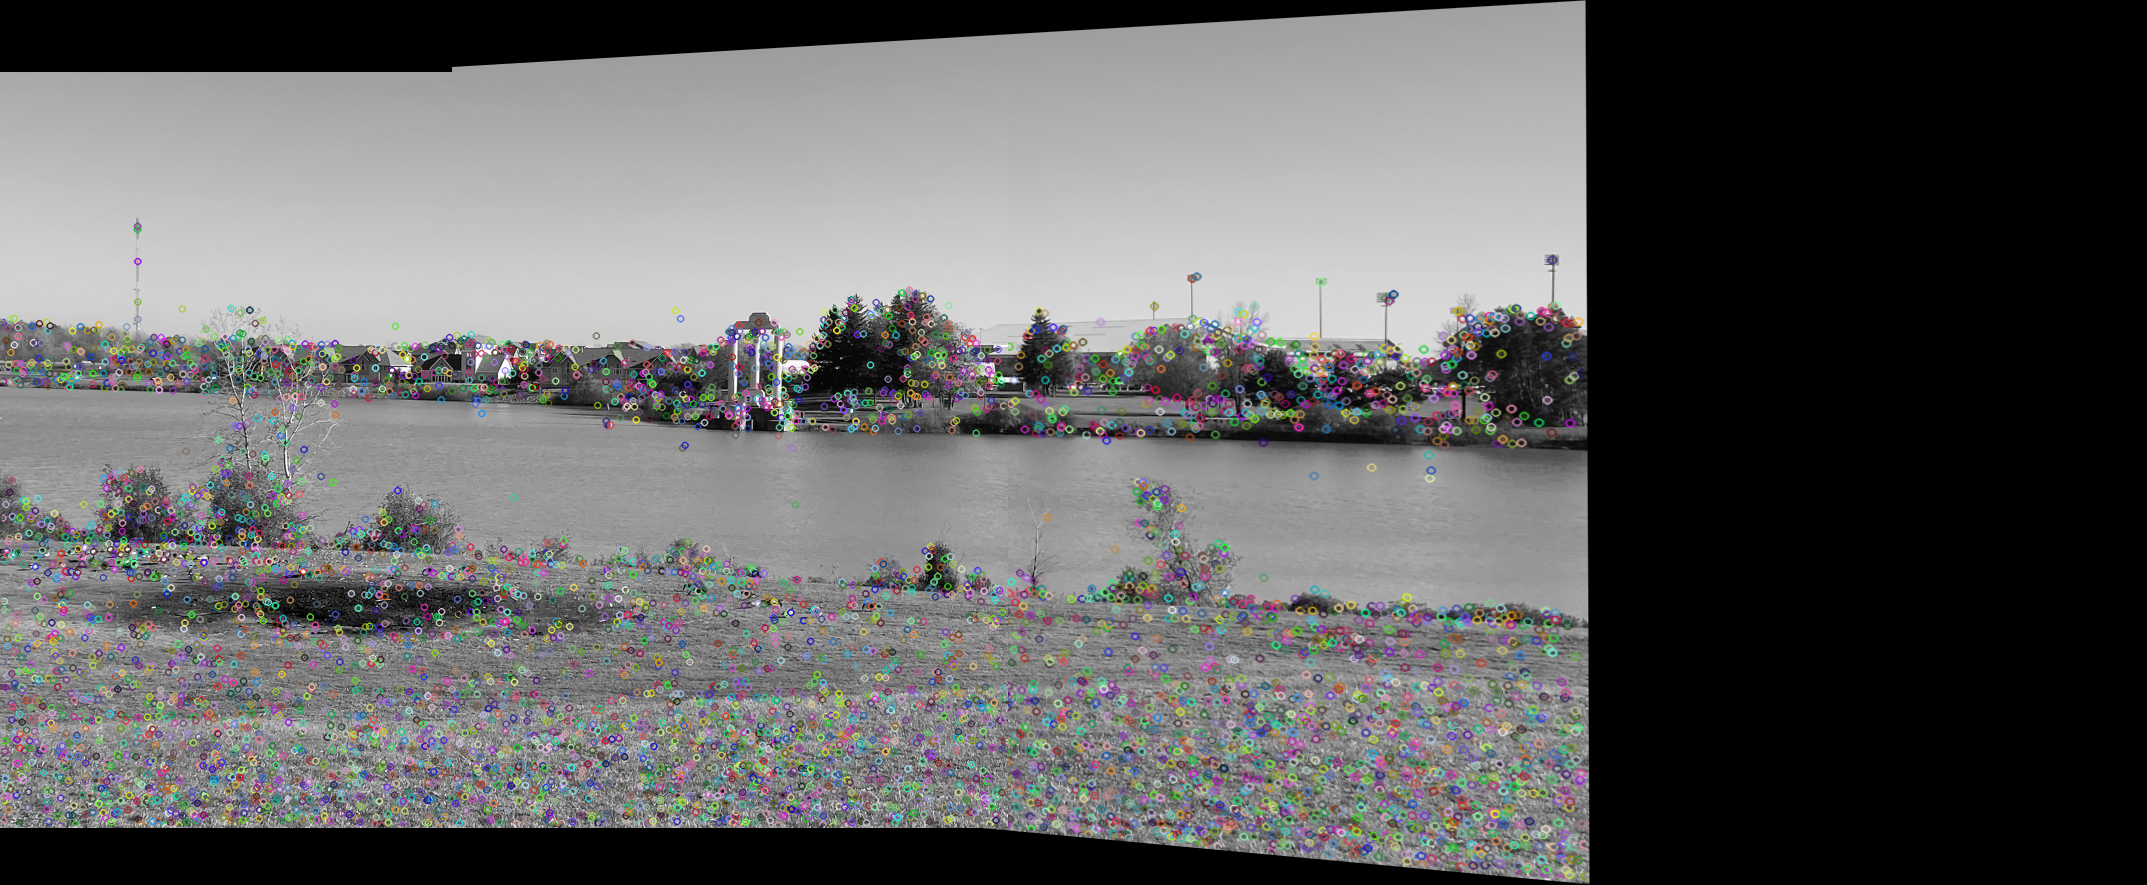

In [4]:
"""
Image Stitching Problem

"""

import cv2
import numpy as np
# np.random.seed(<int>) # you can use this line to set the fixed random seed if you are using np.random
import random
# random.seed(<int>) # you can use this line to set the fixed random seed if you are using random
import math
from google.colab.patches import cv2_imshow
def solution(left_img, right_img):
    """
    :param left_img:
    :param right_img:
    :return: you need to return the result panorama image which is stitched by left_img and right_img
    """
    threshold=0.6
    left_kp,left_des=keypoints_and_descriptors(left_img)
    
    right_kp,right_des=keypoints_and_descriptors(right_img)
    # knn left has key value map of indeces and vals_left has distances
    knn_left,vals_left=calculate_knn(left_des,right_des)
    knn_right,vals_right=calculate_knn(right_des,left_des)
    knn_left=calculate_cross_check(knn_left,knn_right)
    knn_right=calculate_cross_check(knn_right,knn_left)
    kpl,kpr=calculate_ratio_testing_array(knn_left,vals_left,threshold,left_kp,right_kp)
    key_points_right = []
    key_points_left = []

    for x in kpr :
      key_points_right.append(x.pt)

    for x in kpl :
      key_points_left.append(x.pt)

    key_points_right = np.array(key_points_right).astype(np.float32)
    key_points_left = np.array(key_points_left).astype(np.float32)
    H,best_set=calculate_homography_using_ransac_new(key_points_left,key_points_right)
    height, weight = right_img.shape[:2]
    right_img_corners = np.float32([[0, 0], [weight, 0], [weight, height], [0, height]]).reshape(-1, 1, 2)
    transformed_right_corners = cv2.perspectiveTransform(right_img_corners, H)
    x_min = math.floor(transformed_right_corners[:, 0, 0].min())
    y_min = math.floor(transformed_right_corners[:, 0, 1].min())
    x_max = math.ceil(transformed_right_corners[:, 0, 0].max())
    y_max = math.ceil(transformed_right_corners[:, 0, 1].max())
    translate_H = np.array([[1.0,0,0],[0,1,-y_min],[0,0,1]])
    transformed_H = np.matmul(translate_H, H)
    panorama = cv2.warpPerspective(right_img, transformed_H, (math.ceil(x_max - x_min) + left_img.shape[1], math.ceil(y_max - y_min)))
    # cv2_imshow(panorama)
    topPad = -y_min
    panorama[topPad:left_img.shape[0]+topPad, 0:left_img.shape[1]] = left_img
    cv2_imshow(panorama)

    return panorama


def calculate_homography_using_ransac_new(left_img_coordinates,right_image_coordinates):

    n=4
    k = 1000
    t=5
    best_set=[]
    for i in range (k):
      points_set=[]
      random_indeces = random.sample(range(0, len(left_img_coordinates)), 4)
      lpoints = []
      rpoints = []
      for index in random_indeces:
        rpoints.append(right_image_coordinates[index] )
      for index in random_indeces:
        lpoints.append(left_img_coordinates[index] )
      h=calculate_homography(lpoints,rpoints)
      for i in range(len(right_image_coordinates)):
        pi_hat = np.array(h.dot(np.array([right_image_coordinates[i][0],right_image_coordinates[i][1],1])))
        pi_hat=(1/pi_hat[2])*(pi_hat)[0:2]
        pi=np.array(left_img_coordinates[i])
        dist = np.abs( (pi[0] - pi_hat[0]) - (pi[1] - pi_hat[1]) )
        if dist < t:
          points_set.append([right_image_coordinates[i],left_img_coordinates[i]])
      if len(points_set)> len(best_set):
        best_set=points_set
    r_vals=[]
    l_vals=[]
    for v in best_set:
      r_vals.append(v[0])
      l_vals.append(v[1])
    H=calculate_homography(l_vals,r_vals)
    return H,best_set

def calculate_homography(lpoints,rpoints):
    x=0
    y=0
    homography=[]
    for i in range(len(lpoints)):
      x,y=rpoints[i][0],rpoints[i][1]
      x_1,y_1=lpoints[i][0],lpoints[i][1]
      homography.append([x,y,1,0,0,0,-x*x_1,-x_1*y,-x_1])
      homography.append([0,0,0,x,y,1,-y_1*x,-y_1*y,-y_1])
    l,m,V_Transpose=np.linalg.svd(homography)
    H=V_Transpose[8]
    # H=H/H[8]
    H=np.array(H.reshape(3,3))
    return H

def calculate_ratio_testing_array(knn_left,vals_left,threshhold,left_img_kp,right_img_kp):
    knn_l = knn_left.copy()
    left_arr=[]
    right_arr=[]
    for key,value in knn_l.items():
        if vals_left[key][0]<threshhold*vals_left[key][1]:
            left_arr.append(left_img_kp[key])
            right_arr.append(right_img_kp[value[0]])
    return left_arr,right_arr
def calculate_cross_check(knn_left,knn_right):
    knn_l=knn_left.copy();
    for key,value in knn_l.items():
        if value[0] in knn_right or value[1] in knn_right:       
            if((value[0] in knn_right and key in knn_right[value[0]] )or (value[1] in knn_right and key in knn_right[value[1]] )):
              continue;
            else:
                  knn_left.pop(key)  
        else:
            knn_left.pop(key)
    return knn_left

def keypoints_and_descriptors(img):
    grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # print("shape of image is", grey.shape)    
    sift = cv2.xfeatures2d.SIFT_create()
    kp,des = sift.detectAndCompute(grey,None)
    # print("shape of image is", des.shape)
    print("Keypoints on original Image")
    img=cv2.drawKeypoints(grey,kp,img)
    cv2_imshow(img)
    return kp,des

def calculate_knn(left_des,right_des):
      sorted_lis={}
      sroted_vals=[]
      count=0
      for a in left_des:
        indexes=[]
        distance_list=[]
        distance_list = np.sum((right_des-a)**2, axis=1)
        indexes = np.argsort(distance_list)
        distance_list.sort()
        sroted_vals.append(distance_list[0:2])
        sorted_lis[count]=[indexes[0],indexes[1]]
        count+=1
      return sorted_lis,sroted_vals

if __name__ == "__main__":
    np.random.seed(12342)
    left_img = cv2.imread('left.jpg')
    right_img = cv2.imread('right.jpg')
    print("Left image")
    cv2_imshow(left_img)
    print("Right image")
    cv2_imshow(right_img)
    result_img = solution(left_img, right_img)
    # cv2.imshow('results/task1_result.jpg', result_img)




In [ ]:
import numpy as np

a=np.array([[1,3,2],[0,7,4],[6,2,8]]).flatten()
a=np.sort(a)
print(a)
a[4]